# 基于经典网络架构训练图像分类模型

基于 Pytorch 的工具集很多，例如自然语言的 torchtext，处理音频的 torchaudio，以及处理图像视频的 torchvision. 可以直接调用别人已经定义好的模型来进行训练. 同时可以直接调用他们的权重和偏置参数.

Torchvision 的官方文档：<https://pytorch.org/docs/stable/torchvision/index.html>

数据预处理部分：

1. 数据增强: torchvision 模块中的 transforms 模块自带功能, 比较实用
2. 数据预处理: torchvision 中的 transforms 模块也帮我们实现了, 直接调用
3. DataLoader: 读取 batch 数据

网络模块设置

1. 加载预训练模型，利用人家训练好的权重文件来继续训练我们自己的模型
2. 修改成我们自己的任务， 需把最后的 head 层修改，一般就是最后的全连接层，改成我们自己的任务。
3. 训练时可以全部训练，也可以训练我们自己的任务层， 因为前几层都是用来做滕峥提取的。

网络模型的保存和测试

1. 我们可以选择最好的模型进行保存
2. 读取模型进行实际测试

```shell
pip install torchvision
```

上面所说的三个核心模块：

```python
from torchvision import transforms, models, datasets
```

当前任务： 对 102 花进行分类. 文件夹包含训练集和验证集, 每一个文件夹中存放 102 个种类的文件夹, 每一个文件夹存在一个花类型

![flower_data](../assets/3.png)

当前项目的几个特点：

- 数据增强 Data Augmentation(数据夸大): 通过旋转/翻转/放大/缩小等方法将原始数据增加, 从而翻倍测试集. 就不需要用 opencv 进行产出了.
- 图像的 resize, 输入图片的大小可能不同. 会在数据增强中实现.
- json 格式文件读取
- 迁移学习, 读取别人已经定义好的模型, 别人的模型输出个数可能不同, 对其进行调整. 因此不用对权重参数和偏置参数进行修改, 直接继续训练. 传统模型都是用高斯模型来进行初始化, 迁移学习直接用别人的模型进行初始化.
- 保存模型, 调用模型


In [1]:
# 导包
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import torchvision
import imageio  # 用来读取图片数据, 比如将GIF图像保存为PNG图片等等
import time  # 计算时间
import warnings
import random
import sys
import copy
import json

from torch import nn
from torchvision import transforms, models, datasets
from PIL import Image  # Python Imaging Library


In [2]:
# 对读取数据进行操作
data_dir = '../../data/pytorch-flowerdata/flower_data'
train_dir = data_dir + "/train"
valid_dir = data_dir + "/valid"


In [3]:
# 数据增强：增加测试集
# 数据预处理
# data_transforms中指定了所有图像的预处理操作
# imageFolder假设所有文件按照文件夹保存好, 每一个文件夹下面的类型是一样类型的训练数据,文件夹的名字就会变成分类名字
# 这里的对象就是一个配置对象, 所有的类型都是配置类型, 对每一个数据集进行配置, 从而得出Tensor类型的数据
data_transforms = {
    "train": transforms.Compose([
        # 读取的图片进行随机旋转, 从-45度到+45度.
        transforms.RandomRotation(45),
        # 裁剪图片, 所有的图片统一到达分辨率224*224
        transforms.CenterCrop(224),
        # 随机水平翻转, 概率0.5
        transforms.RandomHorizontalFlip(p=0.5),
        # 随机垂直旋转, 概率0.5
        transforms.RandomVerticalFlip(p=0.5),
        # 设定一个颜色的偏执概率, 用来进行颜色的随机生成
        # 亮度随机增加或者减少20%
        # 对比度随机增加或者减少10%
        # 饱和度随机增加或者减少10%
        # 色调随机增加或者减少10%
        transforms.ColorJitter(
            brightness=0.2, contrast=0.1, saturation=0.1, hue=0.1),
        # 2.5%的概率将图片转换为一个灰度图
        transforms.RandomGrayscale(p=0.025),
        # 我们要的结果是一个tensor, 这里注意, tensor中的颜色会将所有的颜色从[0-255]设定为[0-1]
        transforms.ToTensor(),
        # ToTensor()能够把灰度范围从0-255变换到0-1之间，而后面的transform.Normalize()则把0-1变换到(-1,1).
        # 公式为: image=(image-mean)/std
        # 假设mean和std分别通过(0.5,0.5,0.5)和(0.5,0.5,0.5)进行指定。原来的0-1最小值0则变成(0-0.5)/0.5=-1，而最大值1则变成(1-0.5)/0.5=1.
        # 因此如果不清楚设定多少可以直接用  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.255]),
    ]),
    "valid": transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.255]),
    ]),
}


In [4]:
# 各种参数和数据集的封装
batch_size = 8  # 由于输入数据比较大这里的batch就使用比较小的

# python结构, 将train和valid遍历, 然后输出返回到一个json格式中
image_datasets = {
    # 将路径和处理componse传入datasets.ImageFolder读取工序中. 然后它会自动读取这种结构的文件.
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ['train', 'valid']
}
# image_datasets = {
#   'train': Dataset ImageFolder,
#   'valid': Dataset ImageFolder
# }

# 构建torch的dataloader
data_loaders = {
    x: torch.utils.data.DataLoader(
        dataset=image_datasets[x],
        batch_size=batch_size,
        shuffle=True)
    for x in ['train', 'valid']
}

# 将长度放到这个dict中
dataset_size = {x: len(image_datasets[x]) for x in ['train', 'valid']}

# 将训练集的输出结果名封装到list中
class_names = image_datasets['train'].classes
print(class_names)
print(dataset_size)


['1', '10', '100', '101', '102', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']
{'train': 6552, 'valid': 818}


In [5]:
# 这里读取了一个json格式的文件
# 就是一个kv格式的文件, 里面包含了文件夹名称和花名字的映射
# {"21": "fire lily", "3": "canterbury bells", "45"...}
with open('./cat_to_name.json', 'r') as cat_name:
    cat_to_name = json.load(cat_name)

cat_to_name['1']


'pink primrose'

In [6]:
# 将图像从tensor转换为原始的图片类型
def get_image_from_tensor(tensor):
    # clone()函数可以返回一个完全相同的tensor, 新的tensor开辟新的内存，但是仍然留在计算图中
    #   clone()返回的tensor是中间节点，梯度会流向原tensor，即返回的tensor的梯度会叠加在原tensor上
    # detach()函数可以返回一个完全相同的tensor, 新的tensor开辟与旧的tensor共享内存，新的tensor会脱离计算图，不会牵扯梯度计算。
    #   此外，一些原地操作(in-place, such as resize_ / resize_as_ / set_ / transpose_) 在两者任意一个执行都会引发错误。
    #   detach操作在共享数据内存的脱离计算图，所以常用在神经网络中仅要利用张量数值，而不需要追踪导数的场景下。
    # numpy不能读取CUDA tensor 需要将它转化为 CPU tensor, 所以得写成.cpu().numpy()
    image = tensor.to('cpu').clone().detach()

    # squeeze: 从数组的形状中删除单维度条目，即把shape中为1的维度去掉
    # 在机器学习和深度学习中，通常算法的结果是可以表示向量的数组（即包含两对或以上的方括号形式[[]]），
    # 如果直接利用这个数组进行画图可能显示界面为空（见后面的示例）。
    # 我们可以利用squeeze（）函数将表示向量的数组转换为秩为1的数组，这样利用matplotlib库函数画图时，
    # 就可以正常的显示结果了。
    # 比如 np.array(10).reshape(1,2,5).shape 为 (1,2,5), squeeze()以后就变成了(2,5)
    image = image.numpy().squeeze()
    # transpose 作用是改变矩阵序列
    # 按照矩阵的斜线转换, 转置 https://zhuanlan.zhihu.com/p/61203757
    # pytorch的颜色通道放在第一个, C,H,W, 我们需要H,W,C
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.229, 0.224, 0.225)) + \
        np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    return image


# 展示一波
fig = plt.figure(figsize=(20, 12))
column = 4
row = 2
data_iter = iter(data_loaders['valid'])
# inputs, classes = data_iter.next() # 旧版中的方法
inputs, classes = next(data_iter)

for index in range(column * row):
    ax = fig.add_subplot(row, column, index+1, xticks=[], yticks=[])
    ax.set_title(cat_to_name[str(int(class_names[classes[index]]))])
    plt.imshow(get_image_from_tensor(inputs[index]))
plt.show()


4
5
1
2
3
5
1
2
3
5
1
2
3
5
1
2
3
5
1
2
3
5
1
2
3
5
1
2
3
5
1
2
3


## 迁移学习


In [7]:
# 是否用GPU训练
# train_on_gpu = torch.cuda.is_available() # nvidia
train_on_gpu = torch.backends.mps.is_available()  # mac m1

# 创建device模块, 如果使用的是gpu就直接使用gpu进行训练

if not train_on_gpu:
    print('GPU trainning is not available.  Training on CPU ...')
else:
    print('GPU trainning is available!  Training on GPU ...')

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # nvidia
device = torch.device("mps" if train_on_gpu else "cpu")


GPU trainning is available!  Training on GPU ...


In [8]:
# 使用残差网络进行训练, ['resnet','alexnet','vgg','squeeznet','densenet','inception']
model_name = 'resnet'

# 在torchvision的models模块中获取resnet152的数据
model_ft = models.resnet152()
model_ft  # 打印一次model


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## 修改原始数据

在上面的全连接层的最后一层, 输出的 feature 是 1000 个, 因此我们需要修改为我们需要的 102 个

在 python 的源代码中, 我们可以直接调用 init_model 方法, 这里我们对其进行修改

```python
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        # 加入模型
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)
```


In [9]:

# 我们重写了反向传播的方法
# 让我们可以将部分层冻住, 这样反向传播就不会进行反向计算了. 从而达到残差网络的概念
# 这样我们只针对最后一层进行训练
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False


r"""
我们写一个initialize_model方法
"""


def initialize_model(feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 0

    """ 
    resnet152
    """
    # 加入模型
    model_ft = models.resnet152(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.fc.in_features
    # 我们重写最后一层, 这里对最后一层的输出进行赋值, 这里参考了github上的
    model_ft.fc = nn.Sequential(
        nn.Linear(num_ftrs, 102), nn.LogSoftmax(dim=1))
    input_size = 224

    return model_ft, input_size


In [10]:
# 进行训练前的特征查看
# 特征是否进行训练可以进行比较, 如果不需要我们可以关闭特征loss传播. 案例中我们只进行使用不会对网络进行修改

# 是否直接使用特征
feature_extract = True

# 初始化的时候是会下载模型的, 下载的位置是cache目录
model_ft, input_size = initialize_model(feature_extract, use_pretrained=True)

# GPU计算, 将数据放入图像缓存
model_ft = model_ft.to(device)

# 获取模型所有的参数, 然后打印一遍, 这里我们查看通过指定的参数来决定是否训练所有的层
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print('\t', name)
else:
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print('\t', name)

model_ft


/Users/shuowang/opt/anaconda3/envs/python/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/shuowang/opt/anaconda3/envs/python/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Params to learn:
	 fc.0.weight
	 fc.0.bias


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
# 对欧化器进行设置
optimizer = optim.Adam(params_to_update, lr=1e-2)  # 学习率0.01
# 修正学习率(动态学习率), 每7个epoch衰减为原来的10%
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
# 同样使用交叉熵算法
# 但是由于最后一层已经是softmax, 因此不用nn.CrossEntropyLoss()来进行学习,
# 因为nn.CrossEntropyLoss()包含logSoftmax()和nn.NLLLoss()
criterion = nn.NLLLoss()


In [12]:
# 编写训练模型
# 代码是由其他模型抄取过来的, is_inception 表示是否加入其他随机网络来进行对比
def train_model(
    model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False
):
    start_time = time.time()
    best_acc = 0  # 我们对模型进行多次迭代, 找到一个最符合的epoch来进行保存, 以免模型过拟合

    # 使用gpu, 注意如果使用的话需要每次都将数据传入gpu缓存： inputs = inputs.to(device)
    model.to(device)

    # 用于展示的容器, 如果不需要可以删掉
    val_acc_history = []
    train_acc_history = []
    train_losses = []
    valid_losses = []

    # 获取优化其中的学习率
    LRs = [optimizer.param_groups[0]["lr"]]

    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        print("epoch {}/{}".format(epoch, num_epochs - 1))
        print("-" * 10)

        # 每一个epoch先训练后测试, 测试时间会极其庞大
        for job in ["train", "valid"]:
            if job == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[job]:
                # 将数据传入gpu缓存
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 梯度清零
                optimizer.zero_grad()

                # 只有在训练阶段进行更新梯度
                with torch.set_grad_enabled(job == "train"):
                    # 多个模型的情况下进行比较, 这里不可能出现
                    if is_inception and job == "train":
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4 * loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # 反向传播
                    if job == "train":
                        loss.backward()
                        # 在新版本中, 优化器的step方法已经标记为deperacate, 取而代之的是使用scheduler的step方法
                        # optimizer.step()
                        scheduler.step()

                running_loss += loss.item() * inputs.size(0)  # 获取损失值
                running_corrects += torch.sum(preds == labels.data)  # 获取正确率

            # 计算平均损失值和平均准确率
            epoch_loss = running_loss / len(dataloaders[job].dataset)
            # 注意: mac的mps只支持float32, 只有cuda才支持double也就是float64
            # epoch_acc = running_corrects.double(
            # ) / len(dataloaders[job].dataset)
            epoch_acc = running_corrects.float() / len(dataloaders[job].dataset)

            # 打印用时
            time_elapsed = time.time() - start_time
            print(
                "Time elapsed {:.0f}m {:.0f}s".format(
                    time_elapsed // 60, time_elapsed % 60
                )
            )
            print("{} Loss: {:.4f} Acc: {:.4f}".format(job, epoch_loss, epoch_acc))

            # 得到最好那次的模型
            # 如果验证集的时候, 我得到的准确率最高, 那么就把准确率记录起来
            # 然后将模型存入硬盘
            if job == "valid" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())  # 官网给定的权重复制
                state = {
                    "state_dict": model.state_dict(),
                    "best_acc": best_acc,
                    "optimizer": optimizer.state_dict(),
                }
                torch.save(state, "../models/flower.pth")  # 存入到本地硬盘

            # 在训练的时候和验证的时候, 将损失值都打印出来
            if job == "valid":
                val_acc_history.append(epoch_acc)
                valid_losses.append(epoch_loss)
                scheduler.step(epoch_loss)
            if job == "train":
                train_acc_history.append(epoch_acc)
                train_losses.append(epoch_loss)

        # 打印学习率
        print(
            "Optimizer learning rate : {:.7f}".format(optimizer.param_groups[0]["lr"])
        )
        LRs.append(optimizer.param_groups[0]["lr"])
        print()

    # 打印时间
    time_elapsed = time.time() - start_time
    print(
        "Training complete in {:.0f}m {:.0f}s".format(
            time_elapsed // 60, time_elapsed % 60
        )
    )
    print("Best val Acc: {:4f}".format(best_acc))

    # 训练结束后, 将最好的epoch模型加载进去, 并不是最后一个训练结果
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history, valid_losses, LRs


In [13]:
# 训练模型！
model, val_acc_history, train_acc_history, valid_losses, LRs = train_model(model_ft, data_loaders, criterion,
                                                                           optimizer, num_epochs=20, is_inception=False)


epoch 0/19
----------


/Users/shuowang/opt/anaconda3/envs/python/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Time elapsed 1m 53s
train Loss: 4.6920 Acc: 0.0131
Time elapsed 2m 3s
valid Loss: 4.7108 Acc: 0.0061


/Users/shuowang/opt/anaconda3/envs/python/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Optimizer learning rate : 0.0100000

epoch 1/19
----------
Time elapsed 3m 54s
train Loss: 4.6949 Acc: 0.0113
Time elapsed 4m 3s
valid Loss: 4.7156 Acc: 0.0049
Optimizer learning rate : 0.0100000

epoch 2/19
----------
Time elapsed 5m 53s
train Loss: 4.6929 Acc: 0.0118
Time elapsed 6m 2s
valid Loss: 4.7187 Acc: 0.0049
Optimizer learning rate : 0.0100000

epoch 3/19
----------
Time elapsed 7m 52s
train Loss: 4.6948 Acc: 0.0113
Time elapsed 8m 1s
valid Loss: 4.7127 Acc: 0.0049
Optimizer learning rate : 0.0100000

epoch 4/19
----------
Time elapsed 9m 53s
train Loss: 4.6938 Acc: 0.0111
Time elapsed 10m 2s
valid Loss: 4.7133 Acc: 0.0037
Optimizer learning rate : 0.0100000

epoch 5/19
----------
Time elapsed 11m 55s
train Loss: 4.6939 Acc: 0.0124
Time elapsed 12m 5s
valid Loss: 4.7126 Acc: 0.0037
Optimizer learning rate : 0.0100000

epoch 6/19
----------
Time elapsed 13m 58s
train Loss: 4.6897 Acc: 0.0124
Time elapsed 14m 7s
valid Loss: 4.7108 Acc: 0.0061
Optimizer learning rate : 0.0100000

## 全部训练

上面的案例中, `set_parameter_requires_grad`函数我们将所有的层的反向传播全部冻住, 不对其进行计算. 因此所用的时间还是比较小的. 一旦我们对所有的 152 层全部计算, 计算的消耗是非常庞大的.


In [14]:
# 每一层的参数全部开启反向传播
for param in model_ft.parameters():
    param.requires_grad = True

# 训练所有的参数, 我们将学习率设置的更小一点
optimizer = optim.Adam(params_to_update, lr=1e-4)  # 学习率0.0001
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
criterion = nn.NLLLoss()

# 进行训练, 这里我们取出我们的神经网络模型, 然后基于网络模型进行训练, 读取以后其实是一个json, 然后读取全部的权重参数
# state = {
#   'state_dict': model.state_dict(),
#   'best_acc': best_acc,
#   'optimizer': optimizer.state_dict(),
# }
checkpoint = torch.load("../models/flower.pth")
best_acc = checkpoint['best_acc']
model_ft.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])

# 训练全部模型
# 由于全部开启, 模型训练的速度会翻数倍
model, val_acc_history, train_acc_history, valid_losses, LRs = train_model(model_ft, data_loaders, criterion,
                                                                           optimizer, num_epochs=20, is_inception=False)


epoch 0/19
----------
Time elapsed 4m 8s
train Loss: 4.6906 Acc: 0.0111
Time elapsed 4m 17s
valid Loss: 4.7166 Acc: 0.0037
Optimizer learning rate : 0.0001000

epoch 1/19
----------
Time elapsed 8m 25s
train Loss: 4.6938 Acc: 0.0125
Time elapsed 8m 35s
valid Loss: 4.7152 Acc: 0.0024
Optimizer learning rate : 0.0001000

epoch 2/19
----------
Time elapsed 12m 42s
train Loss: 4.6944 Acc: 0.0118
Time elapsed 12m 51s
valid Loss: 4.7102 Acc: 0.0024
Optimizer learning rate : 0.0001000

epoch 3/19
----------
Time elapsed 16m 59s
train Loss: 4.6924 Acc: 0.0113
Time elapsed 17m 8s
valid Loss: 4.7127 Acc: 0.0061
Optimizer learning rate : 0.0001000

epoch 4/19
----------
Time elapsed 21m 17s
train Loss: 4.6919 Acc: 0.0114
Time elapsed 21m 26s
valid Loss: 4.7162 Acc: 0.0049
Optimizer learning rate : 0.0001000

epoch 5/19
----------
Time elapsed 25m 34s
train Loss: 4.6906 Acc: 0.0107
Time elapsed 25m 43s
valid Loss: 4.7142 Acc: 0.0073
Optimizer learning rate : 0.0001000

epoch 6/19
----------
Time e

## 模型测试

定义一个方法, 然后我们输入一张图片, 然后根据这个图片进行预测结果. 此时我们还是要将我们训练好的模型加载进来

数据的处理：

- 测试数据处理方法需要跟训练时一致才可以
- crop 操作的目的是保证输入的大小是一致的
- 标准化操作也是必须的，用跟训练数据相同的 mean 和 std,但是需要注意一点训练数据是在 0-1 上进行标准化，所以测试数据也需要先归一化
- 最后一点，PyTorch 中颜色通道是第一个维度，跟很多工具包都不一样，需要转换


In [15]:
# 数据预处理
def process_image(image_path):
    # 读取测试数据
    img = Image.open(image_path)
    # PIL 的 Resize,thumbnail方法只能进行缩小，所以进行了判断
    # Image.thumbnail() 将此图像变成一个缩略图。该方法将图像修改为包含一个自身的缩略图版本，不大于给定的尺寸。
    # 这个方法计算出一个合适的缩略图尺寸，以保留图像的外观，调用draft()方法来配置文件阅读器（如适用），最后调整图像的大小。
    # 比如：
    #  image = Image.open(r"C:\Users\System-Pc\Desktop\house.jpg")
    #  image.thumbnail((500, 500)) # 500x500的图片
    if img.size[0] > img.size[1]:
        img.thumbnail((10000, 256))
    else:
        img.thumbnail((256, 10000))
    # Crop操作
    left_margin = (img.width-224)/2
    bottom_margin = (img.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    img = img.crop(
        (left_margin, bottom_margin, right_margin, top_margin)
    )
    # 相同的预处理方法, 先做归一化, 和训练集一致
    img = np.array(img)/255
    mean = np.array([0.485, 0.456, 0.406])  # provided mean
    std = np.array([0.229, 0.224, 0.225])  # provided std
    img = (img - mean)/std

    # 注意颜色通道应该放在第一个位置 torch和IMAGE的读取是不同的
    img = img.transpose((2, 0, 1))

    return img


In [16]:
model_ft, input_size = initialize_model(feature_extract, use_pretrained=True)
# GPU模式
model_ft = model_ft.to(device)

# 然后通过读取文件将权重直接读取进来
checkpoint = torch.load("../models/flower.pth")
best_acc = checkpoint['best_acc']
model_ft.load_state_dict(checkpoint['state_dict'])


<All keys matched successfully>

<AxesSubplot: >

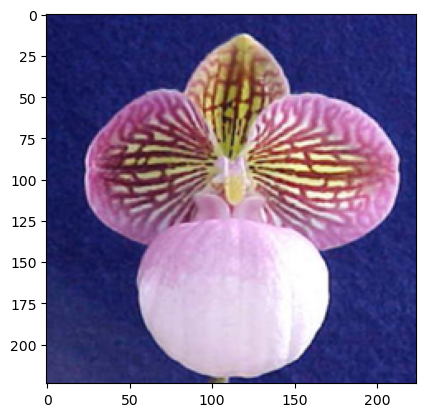

In [17]:
def imshow(image, ax=None, title=None):
    """展示数据"""
    if ax is None:
        fig, ax = plt.subplots()

    # 颜色通道还原
    image = np.array(image).transpose((1, 2, 0))

    # 预处理还原
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.set_title(title)

    return ax


image_path = "../../data/pytorch-flowerdata/flower_data/valid/2/image_05094.jpg"
img = process_image(image_path)
imshow(img)


In [28]:
# 得到一个batch的测试数据
dataiter = iter(data_loaders['valid'])
model_ft.eval()

if train_on_gpu:
    images, labels = next(dataiter)
    input = images.to(device)
    output = model_ft(input)
else:
    images, labels = next(dataiter)
    output = model_ft(images)


In [29]:
output.shape

torch.Size([8, 102])

In [30]:
# 预测, 然后得到概率最大的哪一个
_, preds_tensor = torch.max(output, 1)

preds = np.squeeze(preds_tensor.cpu().numpy())
preds


array([44, 99, 30, 44, 44, 71, 49, 28])

1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3


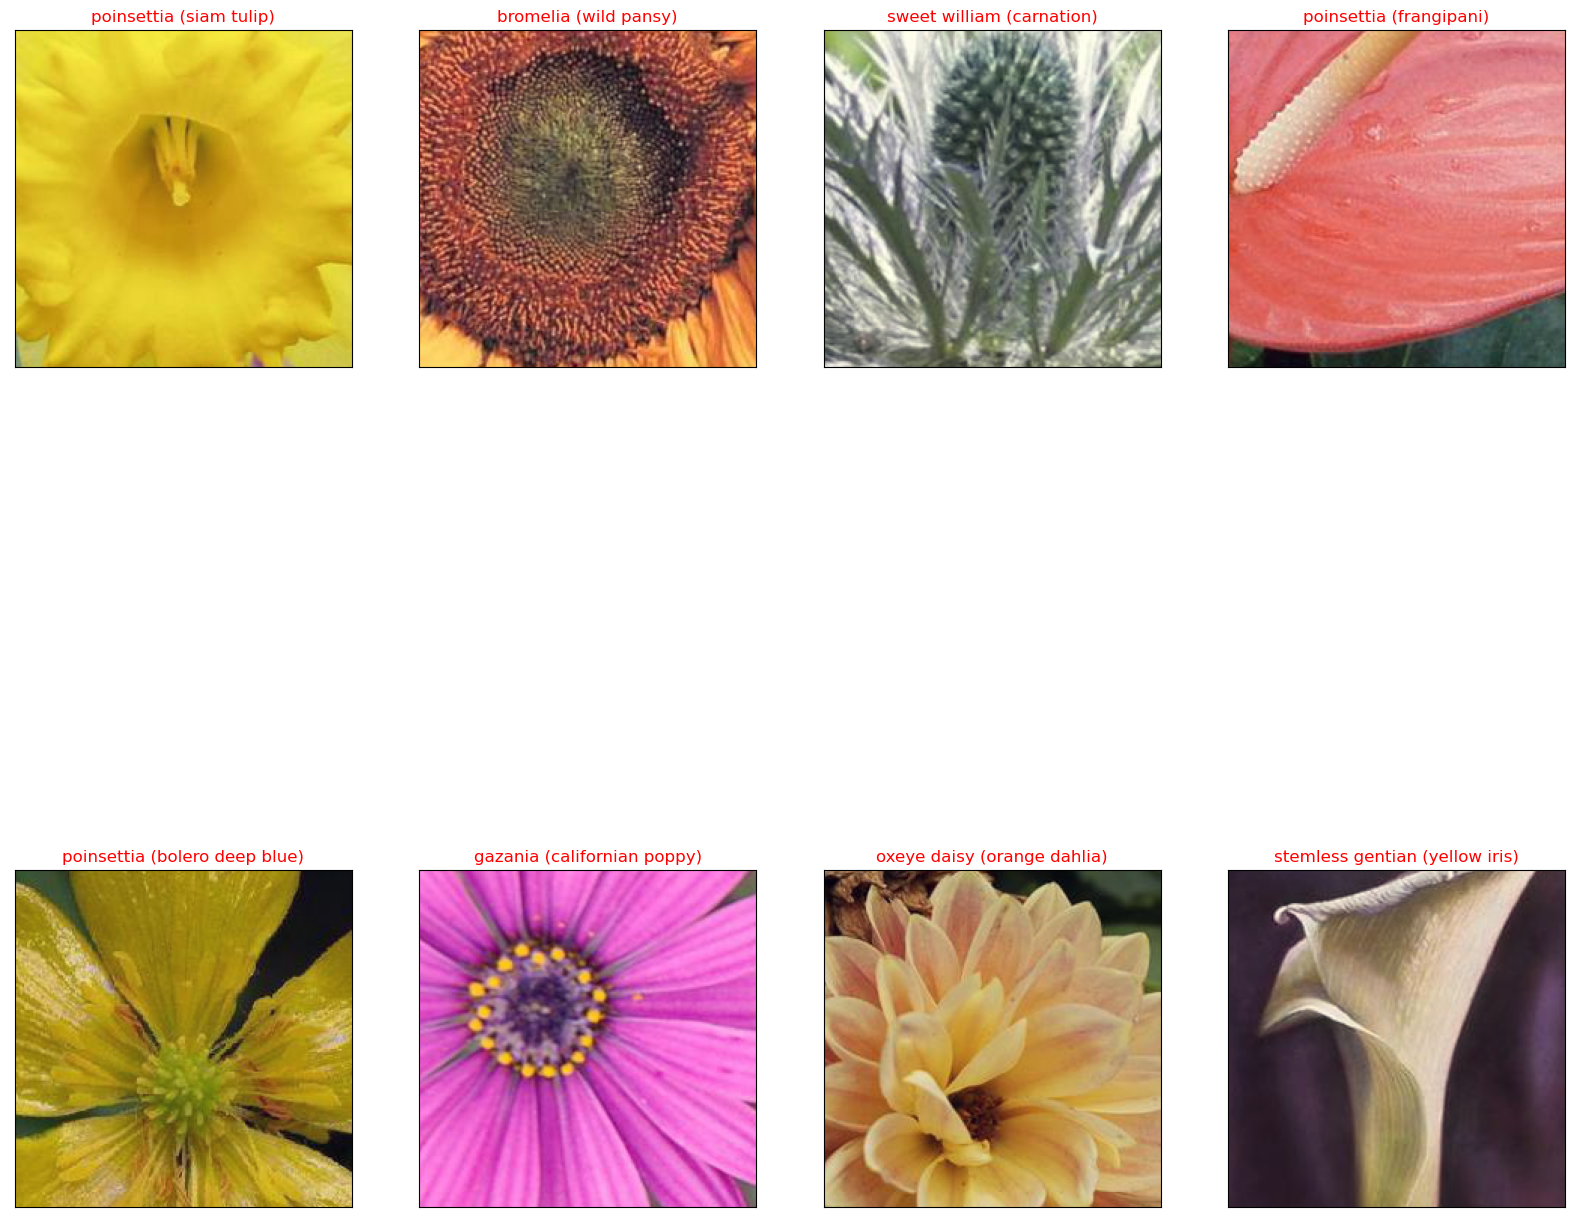

In [31]:
# 展示结果
fig = plt.figure(figsize=(20, 20))
columns = 4
rows = 2

for idx in range(columns*rows):
    ax = fig.add_subplot(rows, columns, idx+1, xticks=[], yticks=[])
    plt.imshow(get_image_from_tensor(images[idx]))
    ax.set_title("{} ({})".format(cat_to_name[str(preds[idx])], cat_to_name[str(labels[idx].item())]),
                 color=("green" if cat_to_name[str(preds[idx])] == cat_to_name[str(labels[idx].item())] else "red"))
plt.show()
